In [1]:
from sklearn.preprocessing import OneHotEncoder
from user_agents import parse

import pandas as pd
import random
import os
import numpy as np
import ipaddress
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42
def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()
path2data = 'notebooks/part_10.csv'
data = pd.read_csv(path2data)
data.shape

def check_ip(ip):
    try:
        ipaddress.ip_address(ip)
    except ValueError:
        return False
    else:
        return True

def spit_by_user_agent(row):
    # Некоторые User-Agent с приставкой "User-Agent: "
    try:
        if "User-Agent: " in row:
            splited = row.split("User-Agent: ")
            return splited[1]
        else:
            return row
    except:
        return row
    
def get_invalid_size(row):
    try:
        int(row)
        return False
    except:
        return True

def get_invalid_code(row):
    try:
        if len(str(row))>3:
            return True
        else:
            return False
    except:
        return True
    
def get_user_agent_info(data):
    "Достаем мета инфу с User-Agent"
    browser_family = []
    os_family = []
    device_brand = []
    
    for agent in data['CLIENT_USERAGENT']:
        user_agent = parse(agent)
        browser_family.append(user_agent.browser.family)
        os_family.append(user_agent.os.family)
        device_brand.append(user_agent.device.brand)
        
    return browser_family, os_family, device_brand
    
def prepare_data(data):
    
    # Убираем дубли
    data.drop_duplicates(keep='first', inplace=True)
    #data = data.reset_index(drop=True)
    
    # Поправляем CLIENT_USERAGENT и заполняем пропуски None
    # В данном случае я считаю, что лучше None оставить как отдельный класс
    data['CLIENT_USERAGENT'] = data['CLIENT_USERAGENT'].apply(spit_by_user_agent).fillna('None')
    
    # Формируем фичу на валидность IP
    data['VALID_IP'] = data['CLIENT_IP'].apply(check_ip).astype('int')
    
    # Достаем инфу из User Agent
    browser_family, os_family, device_brand = get_user_agent_info(data)
    
    # Формируем новые фичи
    data['browser_family'.upper()] = browser_family
    data['os_family'.upper()] = os_family
    data['device_brand'.upper()] = device_brand
    
    # В данном случае я тоже оставляю None как отдельный класс
    data['DEVICE_BRAND'] = data['DEVICE_BRAND'].fillna('Other')
    
    # SUSPICIOUS_DATA
    suspicious_data = [(data['MATCHED_VARIABLE_SRC'].isna()) &
                       (data['MATCHED_VARIABLE_NAME'].isna()) &
                       (data['MATCHED_VARIABLE_VALUE'].isna()) &
                       (data['EVENT_ID'].isna())][0].astype('int').values

    data['SUSPICIOUS_DATA'] = suspicious_data
    
    # INVALID_SIZE
    invalid_size = data['REQUEST_SIZE'].apply(get_invalid_size)
    data['INVALID_SIZE'] = invalid_size.astype('int')
    
    #INVALID_CODE
    invalid_code = data['RESPONSE_CODE'].apply(get_invalid_code)
    data['INVALID_CODE'] = invalid_code.astype('int')
    # Ранее мы выяснили что у нас довольно много запросов с одного CLIENT_IP + CLIENT_USERAGENT
    # Поэтому я решил считать эту связку как уникальный идентификатор пользователя по запросу
    # Группируем строчки по 'CLIENT_IP', 'CLIENT_USERAGENT' и берем первый элемент
    train = data.groupby(by = ['CLIENT_IP', 'CLIENT_USERAGENT']).first().reset_index()
    return train


def create_cat_features(data, cat_colls):
    enc = OneHotEncoder(handle_unknown='ignore')
    # Выбираем категориальные фики и вещественные фичи
    cat_features = data[cat_colls]
    enc.fit(cat_features)
    
    cat_data = enc.transform(cat_features)
    cat_data = cat_data.toarray()
    new_cat_features = enc.get_feature_names()
    
    new_cat_data = pd.DataFrame(data=cat_data, columns=new_cat_features)
    return new_cat_data, enc

# Подготавливаем данные

# Какие фичи использовать для кластеризации запросов?

- **CLIENT_USERAGENT**
 1. BROWSER_FAMILY - имя браузера
 2. OS_FAMILY - наименование операционной системы
 3. DEVICE_BRAND - бренд устройство

Если по всем значениям None - то запрос CLIENT_USERAGENT скорей всего не валидный

- **CLIENT_IP**
 1. IP_VALID - просто проверим валидность айпишника и сделаем бинарный признак
 
 
- **REQUEST_SIZE**
 1. INVALID_SIZE - проверим на большую строку типа AVdieg2Cq1Ppo9zF5x-r - и сделаем бинарный признак


- **RESPONSE_CODE**
 1. INVALID_CODE - тоже самое что и с VALID_SIZE


- **MATCHED_VARIABLE_SRC, MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE, EVENT_ID**
 1. SUSPICIOUS_DATA - бинарная фиче отсутвие значений в этих полях

In [2]:
train = prepare_data(data)

In [3]:
full_colls = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_BRAND', 'VALID_IP', 'SUSPICIOUS_DATA', 'INVALID_SIZE', 'INVALID_CODE']
num_colls = [ 'VALID_IP', 'SUSPICIOUS_DATA', 'INVALID_SIZE', 'INVALID_CODE']
cat_colls = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_BRAND']
new_train, enc = create_cat_features(train, cat_colls)
new_train[num_colls] = train[num_colls]
new_train = new_train.astype('float')


/Users/u18571158/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Попробуем кластеризовать наши данные ипользуя алгоритм K-Means.
### K-Means - алгоритм оптимизирует межкластерное расстояние и не требует сложной настройки

В итоговых данных получится очень много дублей, в классической (обычной) ситуации нам следовало бы их поудалять и оставить только уникальные строки, но в нашем случае я этого делать не буду, так как каждая строка это уникальный запрос со своим IP и User Agent

# Понижение размерности и обучение модели
## (canceled) sklearn tsne не поддерживает встраивание, openTSNE при сохранении весит 200мб



- Понижать размерность будем до 2 с помощью алгоритма TSNE

In [4]:
# from openTSNE import TSNE

# tsne = TSNE(
#     n_components=2,
#     perplexity=30,
#     n_jobs=8,
#     random_state=random_state,
#     verbose=True,
# )

# embedding_train = tsne.fit(new_train.values)
# projections = embedding_train.transform(new_train.values)

# Для кластеризации я решил взять K-mean, так как он прост в настройке

## Надо понять какое кол-во кластеров оптимальное

- Для этого использую метод локтя
- Обучение происходит на разреженной матрице (в целом идея не очень хорошая, но надо попробовать)

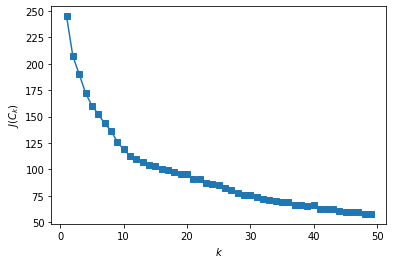

In [5]:
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 50): # 50 - из подсказки)
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(new_train.values)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 50), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

- Видим явный сгиб в районе 11 кластеров

# Обучим  K-Means и визуализируем наши семплы

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11, random_state=random_state).fit(new_train.values)
labels = kmeans.predict(new_train.values)

In [8]:
train['label'] = labels

# Посмотрим на распределение по кластерам

In [9]:
pd.Series(labels).value_counts()

2     7154
7     2834
8     2519
3     2477
6     2435
1     2408
0     2264
5     2248
9     1407
4     1300
10    1253
dtype: int64

# Информативные ли кластера получились относительно нашей концепции плохой/хороший запрос и получилось ли отделить мух от котлет

**Рассмотри результаты самого большого класса**

In [10]:
first_claster = train[labels==2]

- Видим что все CLIENT_USERAGENT - валидные (Кластер хороший)

In [11]:
first_claster

CLIENT_IP                                   CLIENT_USERAGENT  \
16       1.183.96.38  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...   
20       1.241.237.3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
28      1.65.170.222  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...   
30       10.1.72.122  Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...   
31         10.1.72.8  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
...              ...                                                ...   
28202  96.44.147.138  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28203   96.44.147.34  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28204  96.47.226.138  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28205   96.47.226.98  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28208  97.77.151.155  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...   

      REQUEST_SIZE RESPONSE_CODE              MATCHED_VARIABLE_SRC  \
16             821           404                  REQUEST_GET_ARGS   
20            1726           404                  REQUEST_GET_ARGS   
28            1511           404                  REQUEST_GET_ARGS   
30             486           200      REQUEST_URI\';\'REQUEST_ARGS   
31            2277           302                 REQUEST_POST_ARGS   
...            ...           ...                               ...   
28202          946           200                  REQUEST_GET_ARGS   
28203         1174           200                  REQUEST_GET_ARGS   
28204         1046           200                  REQUEST_GET_ARGS   
28205         1112           200                  REQUEST_GET_ARGS   
28208          906           200  REQUEST_METHOD\';\'REQUEST_HEADE   

                           MATCHED_VARIABLE_NAME  \
16                            REQUEST_GET_ARGS._   
20                            REQUEST_GET_ARGS._   
28                            REQUEST_GET_ARGS._   
30                                          file   
31     ctl00$ContentPlaceHolder1$Login2$UserName   
...                                          ...   
28202                       REQUEST_GET_ARGS.st0   
28203                       REQUEST_GET_ARGS.rid   
28204                       REQUEST_GET_ARGS.rid   
28205                       REQUEST_GET_ARGS.rid   
28208            X-Requested-With\';\'CSRF_TOKEN   

                                  MATCHED_VARIABLE_VALUE  \
16                                         1516377129802   
20                                         1516163582259   
28                                             629963454   
30     /front/document.send.php?file=_dumps/..\\..\\....   
31                      <script>alert(\\\'\\\')</script>   
...                                                  ...   
28202                                            КУРУМОЧ   
28203                                         3549613985   
28204                                         3492421678   
28205                                         3517373430   
28208  POST\';\'XMLHttpRequest\';\'14ae90b529b45bd771...   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
16     Bk0PG2QB5cBXmMW1byzz         1         Chrome   Windows        Other   
20     UU9MG2QB5cBXmMW11SQf         1         Chrome   Windows        Other   
28     gLosJWQB5cBXmMW1jLyM         1         Chrome   Windows        Other   
30     MIE72mMBS0qQ_9B6qJiP         1         Chrome   Windows        Other   
31     UIE42mMBS0qQ_9B6-zow         1         Chrome   Windows        Other   
...                     ...       ...            ...       ...          ...   
28202  K2XxHWQB5cBXmMW1Sf8d         1         Chrome   Windows        Other   
28203  6ZxTImQB5cBXmMW1OhLw         1         Chrome   Windows        Other   
28204  _pbQIWQB5cBXmMW1cU5-         1         Chrome   Windows        Other   
28205  ME9SG2QB5cBXmMW1e1RQ         1         Chrome   Windows        Other   
28208  P0nU-GMBE91zVHe8bYdf         1         Chrome  

In [12]:
first_claster['CLIENT_USERAGENT'].value_counts().index[-100:]

Index(['Mozilla/5.0 (Windows; U; Windows NT 6.3) AppleWebKit/534.1.0 (KHTML, like Gecko) Chrome/16.0.880.0 Safari/534.1.0',
       'Mozilla/5.0 (Windows; U; Windows NT 6.0) AppleWebKit/533.1.0 (KHTML, like Gecko) Chrome/13.0.830.0 Safari/533.1.0',
       'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.65 Safari/537.36',
       'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/31.0.1650.57 Safari/537.36',
       'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.103 Safari/537.36',
       'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.101 Safari/537.36',
       'Mozilla/5.0 (Windows; U; Windows NT 5.2) AppleWebKit/531.0.0 (KHTML, like Gecko) Chrome/16.0.866.0 Safari/531.0.0',
       'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3322.3 Safari/537.36',
       'Mozilla/5.0 (Windows NT 10.0; W

- Все IP хорошие

In [13]:
# тут все VALID_IP = 0 IPV6 (видимо скрипт проверки IP это не учитывает)
first_claster[first_claster['VALID_IP'] == 0]

CLIENT_IP  \
9601   2001:7d0:87e2:1480:e870:b625:397   
13465  2a00:1370:8120:29a1:e89b:bb06:6f   
13466  2a00:1370:8120:29a1:f100:f51c:9a   
13467  2a00:1370:812a:1379:3d16:a3b4:88   
13493  2a02:2168:1b49:d900:71e7:9ac2:bf   
13496  2a02:2168:e4e:2300:b6a:2db3:fc95   
13497  2a02:2168:f55:1b00:c589:6624:fb4   
13498  2a02:2698:3c23:65d4:1839:9c8f:ef   
13499  2a02:2698:4c27:37bd:846c:d5bd:49   
13501  2a02:2698:7022:939a:c473:f721:9d   
13502  2a02:2698:7c25:f4dc:409e:83aa:61   

                                        CLIENT_USERAGENT REQUEST_SIZE  \
9601   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          602   
13465  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          623   
13466  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...         2122   
13467  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...         1159   
13493  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...          454   
13496  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          913   
13497  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...          673   
13498  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...          575   
13499  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          529   
13501  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          611   
13502  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          503   

      RESPONSE_CODE MATCHED_VARIABLE_SRC  \
9601            200         REQUEST_ARGS   
13465           200          REQUEST_URI   
13466           200          REQUEST_URI   
13467           200          REQUEST_URI   
13493           200          REQUEST_URI   
13496           200    REQUEST_ARGS_KEYS   
13497           200         REQUEST_ARGS   
13498           200          REQUEST_URI   
13499           200         REQUEST_ARGS   
13501           200         REQUEST_ARGS   
13502           200          REQUEST_URI   

                                   MATCHED_VARIABLE_NAME  \
9601                                              action   
13465                                               None   
13466                                               None   
13467                                               None   
13493                                               None   
13496  customPrice%5B0%5D%5B9%5D=1673&quantity%5B%5D=...   
13497                                             action   
13498                                               None   
13499                                              image   
13501                                                src   
13502                                               None   

                                  MATCHED_VARIABLE_VALUE  \
9601                    dlattach;attach=1073;type=avatar   
13465                     /php/zakaz/zakazSearchById.php   
13466                     /php/zakaz/addNewZakazToDb.php   
13467    /system/cms/themes/madbull/img/horiz_spacer.png   
13493             /system/galery/raboti/18sjg885vmk2.jpg   
13496  customPrice%5B0%5D%5B9%5D=1673&quantity%5B%5D=...   
13497                       profile;area=showposts;u=785   
13498                       /tmp/korporacia_monstr_1.jpg   
13499                        ../imgbasa/483326241916.jpg   
13501                ./../../img/catalogue/item_0768.jpg   
13502                  /www/solutions/09/04/image012.png   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
9601   AVdii6k-q1Ppo9zF506m         0         Chrome   Windows        Other   
13465  AVdWvoUGq1Ppo9zFzP64         0         Chrome   Windows        Other   
13466  AVdm96rgq1Ppo9zF8a8l         0         Chrome   Windows        Other   
13467  AVdhXSutq1Ppo9zF5F4y         0         Chrome   Windows        Other   
13493  AVdl4dgCq1Ppo9zF7qsE         0         Chrome   Windows        Other   
13496  AVdbuRONq1Ppo9zF2HYt         0         Chrome   Windows        Other   
13497  AVdf3ucFq1Ppo9zF4nvF         0         Chrome   Windows        Other   
13498  AVddRxUjq1Ppo9zF3E1q      

**Исходя из этого можно сделать вывод, что этот кластер содержит в себе хорошие запросы (IP + User Agent),  это наши котлеты =)**

In [14]:
second_claster = train[labels==7]

**У второго по частоте кластера с валидность IP + User Agent тоже все хорошо, разлица в кластерах лишь в том, что они поделились по браузерам**

In [15]:
second_claster

CLIENT_IP                                   CLIENT_USERAGENT  \
13       1.160.23.57  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
14     1.165.182.173  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
18      1.221.120.99  Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...   
21       1.33.41.230  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
24      1.47.204.248  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...   
...              ...                                                ...   
28196    95.96.35.94  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
28197    96.242.8.98  Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...   
28206   97.127.71.98  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
28207  97.74.230.213  Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) ...   
28210  98.163.108.72  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   

      REQUEST_SIZE RESPONSE_CODE          MATCHED_VARIABLE_SRC  \
13             778           200              REQUEST_GET_ARGS   
14             295           301              REQUEST_GET_ARGS   
18             681           200              REQUEST_GET_ARGS   
21             445           302              REQUEST_GET_ARGS   
24            1287           404               REQUEST_COOKIES   
...            ...           ...                           ...   
28196          376           301              REQUEST_GET_ARGS   
28197         1275           200              REQUEST_GET_ARGS   
28206          388           302              REQUEST_GET_ARGS   
28207          494           200  REQUEST_URI\';\'REQUEST_ARGS   
28210          390           302              REQUEST_GET_ARGS   

            MATCHED_VARIABLE_NAME  \
13                            url   
14                           addr   
18                        discuss   
21                            url   
24     REQUEST_COOKIES.LtpaToken2   
...                           ...   
28196                        addr   
28197                          id   
28206                         url   
28207             forgot_password   
28210                         url   

                                  MATCHED_VARIABLE_VALUE  \
13     bottompics.uadmin.isaev.info/?a[]=<a href=http...   
14                                    http://ix.sk/yjvjv   
18     999999.9 /**/uNiOn/**/aLl /**/sElEcT null,null...   
21     http://formulaforum.be/wiki/index.php?title=Fo...   
24     fFZdg/9zO1QozMBym9IW1cIp8kAoPxewbIauoR/pn1pOzN...   
...                                                  ...   
28196                         http://firsturl.de/4H17i9h   
28197  63164 or 1=(/**/sElEcT 1 /**/fRoM(/**/sElEcT c...   
28206                         http://firsturl.de/49ZIp7I   
28207  /notification/442225.php?el_id=442225&forgot_p...   
28210                         http://firsturl.de/3Dd55Dj   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
13     AVdoiBA1q1Ppo9zF9JLt         1        Firefox   Windows        Other   
14     AVdkTMGOq1Ppo9zF6sqm         1        Firefox   Windows        Other   
18     AVdmAw5bq1Ppo9zF7vnd         1        Firefox   Windows        Other   
21     AVdwGx13q1Ppo9zFAsX0         1        Firefox   Windows        Other   
24     q7WqJGQB5cBXmMW16UWX         1        Firefox   Windows        Other   
...                     ...       ...            ...       ...          ...   
28196  AVdpD1mLq1Ppo9zF9Ttq         1        Firefox   Windows        Other   
28197  AVdcW8-Pq1Ppo9zF2iLx         1        Firefox   Windows        Other   
28206  AVdnzX7yq1Ppo9zF81Fs         1        Firefox   Windows        Other   
28207  YlGFG2QB5cBXmMW1TgTx         1        Firefox   Windows        Other   
28210  AVdcv-PQq1Ppo9zF2zZn         1        Firefox   Windows        Other   

       SUSPICIOUS_DATA  INVALID_SIZE  INVALID_CODE  label  
13                   0             0             0      7  
14                   0             0             0      7  
18                   0

In [16]:
second_claster['BROWSER_FAMILY'].value_counts()

Firefox    2834
Name: BROWSER_FAMILY, dtype: int64

In [17]:
first_claster['BROWSER_FAMILY'].value_counts()

Chrome    7154
Name: BROWSER_FAMILY, dtype: int64

**Третиий по величине кластер также имеет валидные IP и CLIENT_USERAGENT, криетерием разбиения судя по всему явился Device Brand**

In [18]:
third_claster = train[labels==8]

In [19]:
third_claster['DEVICE_BRAND'].value_counts()

Samsung                   930
Generic_Android           343
XiaoMi                    250
Lenovo                    189
Huawei                    163
Generic_Android_Tablet    115
Generic                    91
Asus                       70
Nokia                      65
ZTE                        52
Sony                       52
LG                         36
HTC                        34
Microsoft                  29
Micromax                   13
Philips                    11
Fly                         8
Prestigio                   8
SonyEricsson                7
Alcatel                     7
BlackBerry                  6
Acer                        6
Spider                      6
OnePlus                     3
Texet                       3
Jiayu                       2
Haier                       2
IconBIT                     2
Oppo                        2
vivo                        1
Vernee                      1
Umeox                       1
Msi                         1
Ployer    

In [20]:
first_claster['DEVICE_BRAND'].value_counts()

Other    7154
Name: DEVICE_BRAND, dtype: int64

In [21]:
second_claster['DEVICE_BRAND'].value_counts()

Other    2834
Name: DEVICE_BRAND, dtype: int64

In [22]:
print(first_claster[first_claster['DEVICE_BRAND'] == 'Other'].shape, first_claster.shape)
print(second_claster[second_claster['DEVICE_BRAND'] == 'Other'].shape, second_claster.shape)

(7154, 16) (7154, 16)
(2834, 16) (2834, 16)


# В каком кластере плохие запросы?

10й кластер содержит подозрительные и плохие запросы

In [24]:
train[train['label'] == 4]

CLIENT_IP  \
0           ý9g³~7ǼAy~è ÷RN1^¤ZϥØÝ
D
FÎ
´
>|   
1                                       >±nß×a¢7ý   
2      ©¬¤\n¸/óîêkOÎÀ
ôzZt©qøӚUÊf©yßSX...   
3      ò­U¬̃ÐÔêsP¯ݦ´ֻڋCü©\tÄ àÔf²kP½z®sn¾ſô#...   
4      \n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...   
...                                                  ...   
28294                             ìújHß.V膢6óã!M]óO÷çIæÿ   
28295  õt2AbÅX;àúT~Á_¥äÆñ§â¦Qý*ù¥ÝýáeØð϶ÜÛæ|¾...   
28296                ù8­<#ÏÏßØÓÆ3rö¦f·۠3M¨L'ÜTؒBõ   
28297                                      ƬÕîzü5ûyÿ   
28298                                                րÿ   

           CLIENT_USERAGENT          REQUEST_SIZE  \
0      AVdtAee3q1Ppo9zF_WoF                  None   
1             SQL Injection  AVdd0K2Rq1Ppo9zF3bg5   
2             SQL Injection  AVdZArWNq1Ppo9zF0txd   
3             SQL Injection  AVdnRu2fq1Ppo9zF8qCY   
4             SQL Injection  AVdfPawjq1Ppo9zF4R4n   
...                     ...                   ...   
28294         SQL Injection  AVdn_D9xq1Ppo9zF87Z-   
28295                  None                  None   
28296                  None                  None   
28297  AVdieeEhq1Ppo9zF5x8y                  None   
28298  AVdo4TiJq1Ppo9zF9OU0                  None   

                          RESPONSE_CODE MATCHED_VARIABLE_SRC  \
0                                  None                 None   
1      81313b14c79a583f202f1ffb179e1f32                 None   
2      96354d8ea79d95995f807edcbc6772b2                 None   
3      82b4c42ac7edc647d27de21ceb791491                 None   
4      5cae7339ed82e2077c9a5da7c92c698a                 None   
...                                 ...                  ...   
28294  0b809ae29d22329a1ca3353f675e3dcf                 None   
28295                              None                 None   
28296                              None                 None   
28297                              None                 None   
28298                              None                 None   

      MATCHED_VARIABLE_NAME MATCHED_VARIABLE_VALUE EVENT_ID  VALID_IP  \
0                      None                   None     None         0   
1                      None                   None     None         0   
2                      None                   None     None         0   
3                      None                   None     None         0   
4                      None                   None     None         0   
...                     ...                    ...      ...       ...   
28294                  None                   None     None         0   
28295                  None                   None     None         0   
28296                  None                   None     None         0   
28297                  None                   None     None         0   
28298                  None                   None     None         0   

      BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  SUSPICIOUS_DATA  INVALID_SIZE  \
0              Other     Other        Other                1             1   
1              Other     Other        Other                1             1   
2              Other     Other        Other                1             1   
3              Other     Other        Other                1             1   
4              Other     Other        Other                1             1   
...              ...       ...          ...              ...           ...   
28294          Other     Other        Other                1             1   
28295          Other     Other        Other                1             1   
28296          Other     Other        Other                1             1   
28297          Other     Other        Other                1             1   
28298          Other     Other        Other                1             1   

       INVALID_CODE  label  
0                 0      4  
1                 1      4  
2                 1

В 4й класс - попали наши плохие запросы

In [32]:
train[train['label'] == 4]

CLIENT_IP  \
0           ý9g³~7ǼAy~è ÷RN1^¤ZϥØÝ
D
FÎ
´
>|   
1                                       >±nß×a¢7ý   
2      ©¬¤\n¸/óîêkOÎÀ
ôzZt©qøӚUÊf©yßSX...   
3      ò­U¬̃ÐÔêsP¯ݦ´ֻڋCü©\tÄ àÔf²kP½z®sn¾ſô#...   
4      \n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...   
...                                                  ...   
28294                             ìújHß.V膢6óã!M]óO÷çIæÿ   
28295  õt2AbÅX;àúT~Á_¥äÆñ§â¦Qý*ù¥ÝýáeØð϶ÜÛæ|¾...   
28296                ù8­<#ÏÏßØÓÆ3rö¦f·۠3M¨L'ÜTؒBõ   
28297                                      ƬÕîzü5ûyÿ   
28298                                                րÿ   

           CLIENT_USERAGENT          REQUEST_SIZE  \
0      AVdtAee3q1Ppo9zF_WoF                  None   
1             SQL Injection  AVdd0K2Rq1Ppo9zF3bg5   
2             SQL Injection  AVdZArWNq1Ppo9zF0txd   
3             SQL Injection  AVdnRu2fq1Ppo9zF8qCY   
4             SQL Injection  AVdfPawjq1Ppo9zF4R4n   
...                     ...                   ...   
28294         SQL Injection  AVdn_D9xq1Ppo9zF87Z-   
28295                  None                  None   
28296                  None                  None   
28297  AVdieeEhq1Ppo9zF5x8y                  None   
28298  AVdo4TiJq1Ppo9zF9OU0                  None   

                          RESPONSE_CODE MATCHED_VARIABLE_SRC  \
0                                  None                 None   
1      81313b14c79a583f202f1ffb179e1f32                 None   
2      96354d8ea79d95995f807edcbc6772b2                 None   
3      82b4c42ac7edc647d27de21ceb791491                 None   
4      5cae7339ed82e2077c9a5da7c92c698a                 None   
...                                 ...                  ...   
28294  0b809ae29d22329a1ca3353f675e3dcf                 None   
28295                              None                 None   
28296                              None                 None   
28297                              None                 None   
28298                              None                 None   

      MATCHED_VARIABLE_NAME MATCHED_VARIABLE_VALUE EVENT_ID  VALID_IP  \
0                      None                   None     None         0   
1                      None                   None     None         0   
2                      None                   None     None         0   
3                      None                   None     None         0   
4                      None                   None     None         0   
...                     ...                    ...      ...       ...   
28294                  None                   None     None         0   
28295                  None                   None     None         0   
28296                  None                   None     None         0   
28297                  None                   None     None         0   
28298                  None                   None     None         0   

      BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  SUSPICIOUS_DATA  INVALID_SIZE  \
0              Other     Other        Other                1             1   
1              Other     Other        Other                1             1   
2              Other     Other        Other                1             1   
3              Other     Other        Other                1             1   
4              Other     Other        Other                1             1   
...              ...       ...          ...              ...           ...   
28294          Other     Other        Other                1             1   
28295          Other     Other        Other                1             1   
28296          Other     Other        Other                1             1   
28297          Other     Other        Other                1             1   
28298          Other     Other        Other                1             1   

       INVALID_CODE  label  
0                 0      4  
1                 1      4  
2                 1

В 5ом класетере наблюдаем наличие ботов

In [30]:
train[train['label'] == 5]['BROWSER_FAMILY'].value_counts()[:10]

AhrefsBot       1077
YandexBot        320
bingbot          200
Googlebot        119
MJ12bot          105
YandexImages      83
Mail.RU_Bot       55
SputnikBot        34
Yahoo! Slurp      26
Other             25
Name: BROWSER_FAMILY, dtype: int64

# Визуализация

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=3
)

projections = tsne.fit_transform(new_train.values)

/Users/u18571158/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/u18571158/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=labels)
fig.update_traces(marker_size=1)
fig.show()

# Довольно не плохо, кластеры разделяются хорошо

# Save model

In [54]:
import joblib

In [55]:
joblib.dump(enc, "src/models/weights/one_hot_enc.joblib")
joblib.dump(kmeans, "src/models/weights/kmeans.joblib")

['src/models/weights/kmeans.joblib']

In [56]:
train.to_csv('result.csv',index=False)

№